# CITS5014/15 Research Project

### Name: Peter Millitz [23088298]   Date: 17/10/2025

# Deep-Learning-Based Techniques for Ship Object Detection and Classification Using Complex-Valued SAR Imagery

## 1. Introduction

This research seeks to investigate the use of high-resolution complex-valued SLC data products from space-based SAR imagery for the tasks of ship detection, classification, and vessel regression using Deep Learning (DL). The basis for this investigation is the hypothesis that fully leveraging the information in the inherently complex-valued SAR imagery should naturally lead to superior model performance compared to real-valued networks. The underlying motivation is to achieve tangible improvements in the performance of existing SAR ship detection models used for maritime surveillance of IUU fishing activity.

## 2. The SARFish dataset

### 2.1 Overview

SARFish is an imagery dataset for the purpose of training, validating and testing supervised machine learning models on the tasks of ship detection, classification and vessel length regression. SARFish builds on the work of the xView3-SAR dataset by expanding the imagery data to include Single Look Complex (SLC) as well as Ground Range Detected (GRD) imagery data taken directly from the European Space Agency (ESA) Copernicus Programme Open Access Hub Website.  

The pre-processing applied to the Sentinel-1 images to the SARFish dataset was chosen to be deliberately minimal. The only operations applied to the SARFish data have been those necessary to make the images usable for computer vison tasks and include flipping, debursting and no-data masking. The philosophy was to provide GRD and SLC data in a format as close as practicable to the Sentinel-1 data that can be downloaded from Copernicus.  

The three operations applied post download are describe below:  

1. **Flipping:** Flipping was applied to both GRD and SLC products. Due to the acquisition methodology, raw images appear as mirror images of the surface of the Earth. This parity inversion between raw images and real-world coordinates is accounted for by reversing the image and its associated ground control points along the range or x-axis. 

2. **Debursting:** Debursting was applied only to SLC products. Sentinel-1 SLC products are provided as sets of 3 "swaths" per channel per scene. These swaths consist of "sub-swaths" or "bursts" which are overlapping segments of the image. The process of de-bursting is the alignment of these bursts into a contiguous image. This was done to create a one-to-one correspondence between the objects in each swath and the features on the Earth to which they correspond. It is important to note that as the deburst images are concatenations of bursts which themselves are individual SAR images, there are significant phase discontinuities on the boundaries of the bursts. It was decided for the purposes of this dataset that the bursts within the individual swaths should be merged rather than being split into separate images.

3. **No data masking:** No data masking was applied to both GRD and SLC products. Invalid pixels in the image have been masked using a 'no data' mask.

### 2.2. Dataset download

All SLC (and corresponding GRD) products from the 50 scenes that comprise the 'validation' partition of the SARFish dataset, were downloaded for this project. The SARFish dataset resides in a Hugging Face repository available for download at: https://huggingface.co/datasets/ConnorLuckettDSTG/SARFish. The validation partition was chosen because of the high prevalence of associated labelling where true vessel detections were of `HIGH` and `MEDIUM` confidence and bounding box coordinates were present. In contrast, the 'train' partition, although having many more scenes, entirely lacked labels with 'HIGH' confidence true vessel detections. Moreover, the majority of MEDIUM confidence labels did not have bounding boxes. The exact selection criteria for SLC images based on associated groundtruth labels is shown in Table 1 below.

Table 1. Label criteria required for SLC image selection.

|  Attribute |      Value(s)     |
|:-----------|:------------------|
|  is_vessel |        True       |
| is_fishing |   True, False     |
| confidence |   HIGH, MEDIUM    |
|     top    |    not missing    |
|     left   |    not missing    |
|   bottom   |    not missing    |
|    right   |    not missing    |

A script, kindly supplied by one of the principal authors of the dataset^1, was customised to selectively download 50 SLC scenes selected from the validation partition (see script: *downloader/download_specific_files_from_the_SARFish_dataset_mod.py*). The script requires a specific python environment setup. The *requirements.txt* file used to create the python environment is included in the downloader directory.

* Note: due to the debursting operation, each scene comprises three separate swaths (with small overlap), so the total number of images downloaded is actually 150.

[1] Connor Luckett, connor.luckett@defence.cgov.au

## 3. Setup

### 3.1 Import required libraries

In [1]:
from pathlib import Path
import os
from time import time

import numpy as np # np.__version__ = 1.26.4 (had to downgrade to version < 2.0)
import pandas as pd
import matplotlib.pyplot as plt # Added by PJM
import yaml
from GeoTiff import load_GeoTiff
from complex_scale_and_norm import process_complex_data
from utilities import *
from batch_sar_processing import *
from compare_crops import crop_compare
from analyse_crop_stats import *

%gui qt
from visualise_labels import scale_sentinel_1_image, SARFish_Plot
#from SARFish_metric import score

pd.set_option('display.max_colwidth', None)

QStandardPaths: XDG_RUNTIME_DIR points to non-existing path '/run/user/11714', please create it with 0700 permissions.


### 3.2 Split the dataset

First create a full list of qualifying validation partition scenes then partition it into train and test scene lists (90:10).

In [2]:
# Create a list of the 50 selected scene ids from the'validation' partition of the SARFish dataset downloaded from Hugging Face
command = "awk -F',' '{print $3}' ./SARFish_labels/validation/SLC/SLC_validation_labels.csv | tail -n +2 | sort -u"
fifty_scenes = extract_list_from_command(command, print_summary=True, columns=5, list_name="fifty_scenes")

Total number of items in fifty_scenes: 50
fifty_scenes = ["0157baf3866b2cf9v","0d8ed29b0760dc59v","0e309957cef7bdc8v","128443d1e98e2839v","13dd786ee6c95e06v"
                ,"204e657a411faf4dv","264ed833a13b7f2av","2e80028071b89173v","335f9a411884e9cbv","36076e547370064ev"
                ,"377410f6ab9824dfv","3808f5703f0920bfv","39268d50efe8dae9v","3ceef682fbe4930av","3fe00bf7beab8812v"
                ,"487b4884f467c94av","4a97701b4bd81bf7v","4da9db72dea50504v","590dd08f71056cacv","5c3d986db930f848v"
                ,"5e9a2c1bcf179e9bv","65d6f6baee882077v","6a2b6ddecd398c6fv","758991708403f218v","75c03770095c6d9ev"
                ,"7b7e837a7ac5a880v","8204efcfe9f09f94v","844545c005776fb1v","94dca5e4de2edcf8v","9a5aa7310c195f14v"
                ,"9b89b9dcce7dc85ev","9c418af4acd217d1v","9ea5029406691ce4v","a1a21a222e244555v","a6073537a4ea5fb9v"
                ,"a9a58462f221a9eev","acf76647ba3f524bv","b1844cde847a3942v","c5ea6da5405bfac0v","c8bbfb37522617e9v"
                ,"cd36e

Ten percent of the 50 scenes will be randomly selected and set aside as the test set for later model evaluation

In [3]:
# Randomly select 10% of scene_ids from the pool of 50 to be set aside as the test set. 
# Store the remainder as the train set to be used for training the model.
train_scene_ids, test_scene_ids = train_test_split(fifty_scenes , test_ratio=0.1, seed=40)

# Display the list of train_scene_ids and save to CSV file
print(f"Number of train scenes: {len(train_scene_ids)}")
print_list_formatted(train_scene_ids, 5, "train_scene_ids")
save_list_to_txt(train_scene_ids, "train_scene_ids.txt")

# Display the list of test_scene_ids and save to CSV file
print(f"Number of test scenes: {len(test_scene_ids)}")
print_list_formatted(test_scene_ids, 5 , "test_scene_ids")
save_list_to_txt(test_scene_ids, "test_scene_ids.txt")

Number of train scenes: 45
train_scene_ids = ["758991708403f218v","c5ea6da5405bfac0v","36076e547370064ev","f298dbd78ef977d5v","65d6f6baee882077v"
                   ,"f9eb760aaf6e798dv","eeddcc0db3cff0d8v","fc483682c621b54bv","9ea5029406691ce4v","3808f5703f0920bfv"
                   ,"c8bbfb37522617e9v","9c418af4acd217d1v","cd4f6ff86f9f5991v","75c03770095c6d9ev","5e9a2c1bcf179e9bv"
                   ,"4a97701b4bd81bf7v","13dd786ee6c95e06v","9b89b9dcce7dc85ev","a6073537a4ea5fb9v","a9a58462f221a9eev"
                   ,"377410f6ab9824dfv","5c3d986db930f848v","7b7e837a7ac5a880v","204e657a411faf4dv","acf76647ba3f524bv"
                   ,"844545c005776fb1v","fe6a8d80fb5ebb8ev","39268d50efe8dae9v","128443d1e98e2839v","e40c9251a4fce150v"
                   ,"fc2f57371370c521v","0d8ed29b0760dc59v","94dca5e4de2edcf8v","4da9db72dea50504v","6a2b6ddecd398c6fv"
                   ,"335f9a411884e9cbv","3ceef682fbe4930av","cd36e75010a021f7v","cdc04ca397865356v","590dd08f71056cacv"
              

## 4. Exploratory Data Analysis

### 4.1 Training labels

Load and examine the labels associated with each train scene_id. The labels are sourced from the master SLC 'validation' partition labels CSV file ('*SLC_validation_labels.csv*').

Note: Only images with the appropriate level of labelling will be retained for training.

In [4]:
# Read the the master SLC 'validation' partition labels CSV file in chunks, filtering on train dataset scene_ids.
df_labels_train = pd.concat(
    filter_rows(chunk, 'scene_id', train_scene_ids)
    for chunk in pd.read_csv('./SARFish_labels/validation/SLC/SLC_validation_labels.csv', chunksize=5000)
)

# Display a few rows
df_labels_train

,partition,product_type,scene_id,detect_id,SLC_product_identifier,swath_index,detect_lat,detect_lon,detect_scene_column,detect_scene_row,...,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
0,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.60344616000000428357_-20.89814321000000063577,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.603446,-20.898143,18083.0,5388.0,...,18079.0,5387.0,18087.0,NaN,manual,True,NaN,0.130777,0.109727,LOW
1,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.60102723999999341231_-20.90357632999999992762,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.601027,-20.903576,18131.0,5365.0,...,18124.0,5363.0,18138.0,NaN,manual,True,NaN,0.142263,0.071051,MEDIUM
2,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.17134473999999499938_-21.09210240000000169402,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.171345,-21.092102,17649.0,1860.0,...,17643.0,1859.0,17652.0,NaN,manual,True,NaN,0.041884,0.509684,MEDIUM
3,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.17062706000000105178_-21.09188649000000026490,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.170627,-21.091886,17642.0,1855.0,...,17635.0,1852.0,17649.0,NaN,manual,True,NaN,0.044895,0.502181,MEDIUM
4,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.70719721999999762829_-20.71366400000000140835,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.707197,-20.713664,16672.0,6335.0,...,16655.0,6331.0,16687.0,NaN,manual,True,NaN,0.015443,2.789757,MEDIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19181,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.46657020399999993288_003.39077283399999984681,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.466570,3.390773,11095.0,9420.0,...,11084.0,9418.0,11105.0,41.662661,manual,True,NaN,0.012979,0.458679,MEDIUM
19182,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.46965017399999986480_003.38507763299999986373,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.469650,3.385078,11299.0,9435.0,...,11285.0,9432.0,11312.0,164.112935,manual,True,NaN,0.109386,0.194906,MEDIUM
19183,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.28999598099999968071_003.23360257100000003661,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.289996,3.233603,15029.0,7806.0,...,14983.0,7799.0,15071.0,234.084314,ais/manual,True,False,9999.990000,9999.990000,HIGH
19184,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.36177788400000032709_003.31700163200000019970,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.361778,3.317002,12791.0,8493.0,...,12748.0,8488.0,12835.0,109.963083,ais/manual,True,False,4.393870,4.767537,HIGH


There are a total of 17,011 label entries across the 45 scenes in the train dataset.

In [5]:
# Check for duplicates
duplicates_val = df_labels_train[df_labels_train.duplicated(subset=['detect_id'], keep=False)]
duplicates_val['detect_id'].value_counts()

5c3d986db930f848v_065.43694542999999441690_-21.17495764999999963152    2
b1844cde847a3942v_005.32469935700000007728_004.31322601100000024843    2
c8bbfb37522617e9v_056.68261086999999776026_008.62931933900000025517    2
c8bbfb37522617e9v_056.55294262000000315993_008.59187207499999949789    2
c8bbfb37522617e9v_056.95005129999999837764_008.69259218999999916377    2
                                                                      ..
f298dbd78ef977d5v_058.08161896000000012918_007.00797728499999994511    2
f298dbd78ef977d5v_058.08344604999999916117_007.00991086600000024021    2
f298dbd78ef977d5v_058.08282033999999782736_007.01011532199999987114    2
f298dbd78ef977d5v_058.08190680999999955247_007.00914851799999993887    2
377410f6ab9824dfv_006.02922705100000033696_003.64273458300000019250    2
Name: detect_id, Length: 245, dtype: int64

245 duplicate detection IDs were found.

Now filter the the dataframe for labels that meet the requirements:

In [6]:
# Filter for true vessels detections which are either fishing or not and for which there is HIGH or MEDIUM confidence and
# where the pixels locations of all four corners of the bounding box are not missing
col_range = ['top', 'left', 'bottom', 'right'] # bounding box corner pixels

df_labels_train_filt = df_labels_train[ ( (df_labels_train['is_vessel'] == True) & (df_labels_train['is_fishing'].notnull() ) &  
                                    ( (df_labels_train['confidence'] == 'HIGH') | (df_labels_train['confidence'] == 'MEDIUM') ) & 
                                       df_labels_train[col_range].notnull().all(axis=1)) ]                                   
# Display a few rows
df_labels_train_filt

,partition,product_type,scene_id,detect_id,SLC_product_identifier,swath_index,detect_lat,detect_lon,detect_scene_column,detect_scene_row,...,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
22,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.98324671999999679883_-20.70595078999999927305,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.983247,-20.705951,18289.0,8503.0,...,18282.0,8500.0,18293.0,9.970000,ais/manual,True,True,9999.990000,9999.990000,HIGH
23,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.60488521000000616823_-21.09645533999999855723,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.604885,-21.096455,20344.0,5257.0,...,20335.0,5255.0,20350.0,11.510000,ais/manual,True,True,7.948565,7.586943,HIGH
25,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.96593518000000244683_-20.62517562000000026501,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.965935,-20.625176,17290.0,8426.0,...,17279.0,8421.0,17298.0,11.100000,ais/manual,True,True,9999.990000,9999.990000,HIGH
30,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_066.13229690999999377254_-19.98992583000000067273,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,66.132297,-19.989926,11494.0,10195.0,...,11489.0,10194.0,11497.0,14.980000,ais/manual,True,True,4.978411,5.240271,HIGH
33,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_066.33721583999999893422_-18.87526499999999884949,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,66.337216,-18.875265,1589.0,12651.0,...,1576.0,12645.0,1599.0,14.800000,ais/manual,True,True,9999.990000,9999.990000,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19179,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.33977017199999970387_003.35668044700000001157,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.339770,3.356680,11364.0,8385.0,...,11345.0,8382.0,11384.0,64.874613,ais/manual,True,False,6.508487,6.698079,HIGH
19180,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.29591264799999983381_003.33278283300000000011,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.295913,3.332783,11848.0,8008.0,...,11816.0,8003.0,11880.0,92.097116,ais/manual,True,False,9999.990000,9999.990000,HIGH
19183,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.28999598099999968071_003.23360257100000003661,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.289996,3.233603,15029.0,7806.0,...,14983.0,7799.0,15071.0,234.084314,ais/manual,True,False,9999.990000,9999.990000,HIGH
19184,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.36177788400000032709_003.31700163200000019970,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.361778,3.317002,12791.0,8493.0,...,12748.0,8488.0,12835.0,109.963083,ais/manual,True,False,4.393870,4.767537,HIGH


There are 3,603 labels in the train dataset that meet the selection criteria.

In [7]:
# Display an abbreviated column version of the previous dataframe
df_labels_train_filt_abv = (df_labels_train_filt[['partition','product_type','scene_id','detect_id','swath_index',
                                                  'detect_scene_column','detect_scene_row','top','left','bottom','right',
                                                  'vessel_length_m','is_vessel','is_fishing','confidence']]
                            .assign(detect_id=lambda x: '...' + x['detect_id'].str[-39:]))
# Display a few rows
df_labels_train_filt_abv.head()

,partition,product_type,scene_id,detect_id,swath_index,detect_scene_column,detect_scene_row,top,left,bottom,right,vessel_length_m,is_vessel,is_fishing,confidence
22,validation,SLC,5c3d986db930f848v,...71999999679883_-20.70595078999999927305,1,18289.0,8503.0,8506.0,18282.0,8500.0,18293.0,9.97,True,True,HIGH
23,validation,SLC,5c3d986db930f848v,...21000000616823_-21.09645533999999855723,1,20344.0,5257.0,5259.0,20335.0,5255.0,20350.0,11.51,True,True,HIGH
25,validation,SLC,5c3d986db930f848v,...18000000244683_-20.62517562000000026501,1,17290.0,8426.0,8431.0,17279.0,8421.0,17298.0,11.10,True,True,HIGH
30,validation,SLC,5c3d986db930f848v,...90999999377254_-19.98992583000000067273,1,11494.0,10195.0,10196.0,11489.0,10194.0,11497.0,14.98,True,True,HIGH
33,validation,SLC,5c3d986db930f848v,...83999999893422_-18.87526499999999884949,1,1589.0,12651.0,12656.0,1576.0,12645.0,1599.0,14.80,True,True,HIGH


The abbreviated display sample, above, shows the columns used for the selection cirteria: 'is_vessel' == True, 'is_fishing' is not missing and confidence has a valid value and all bounding box coordinates are populated. 

Determine if any any swaths have missing labels:

In [8]:
# First, get the full set of expected swath indices
expected_swaths = set([1, 2, 3])
# Group by scene_id_ and collect the actual swath indices
swaths_with_labels = df_labels_train_filt.groupby('scene_id')['swath_index'].apply(set).reset_index(name='swaths_with_labels')
# Find the difference between expected and actual for each scene
swaths_with_labels['swaths_missing_labels'] = swaths_with_labels['swaths_with_labels'].apply(lambda x: expected_swaths - x)
# Filter down to scenes missing one or more swaths
scenes_with_gaps = swaths_with_labels[swaths_with_labels['swaths_missing_labels'].apply(len) > 0]
# Display scenes with one or more swaths with missing labels
scenes_with_gaps

,scene_id,swaths_with_labels,swaths_missing_labels
1,0e309957cef7bdc8v,{3},"{1, 2}"
2,128443d1e98e2839v,"{1, 2}",{3}
3,13dd786ee6c95e06v,"{1, 2}",{3}
10,3ceef682fbe4930av,"{1, 2}",{3}
17,65d6f6baee882077v,"{1, 2}",{3}
20,75c03770095c6d9ev,"{2, 3}",{1}
22,844545c005776fb1v,"{1, 2}",{3}
24,9a5aa7310c195f14v,"{1, 2}",{3}
31,acf76647ba3f524bv,"{1, 3}",{2}
34,c8bbfb37522617e9v,"{1, 3}",{2}


Ten scenes have at least one swath without labels.

In [9]:
# Determine the number of unique scene_id/swath_index combinations present. 
# This will indicate the total number of images that meet the selection criteria.
unique_combinations = df_labels_train_filt[['scene_id', 'swath_index']].drop_duplicates()
count_images = len(unique_combinations)
print(f"Number of unique scene_id/swath_index entries: {count_images}")

Number of unique scene_id/swath_index entries: 124


In [10]:
# Count and display the number of 'HIGH' and 'MEDIUM' confidence labels (including duplicates) in the train dataset
labels_count = df_labels_train_filt['confidence'].value_counts()
print(labels_count[['HIGH', 'MEDIUM']])

HIGH      3559
MEDIUM      44
Name: confidence, dtype: int64


In [11]:
# Count and display the number of non-fishing vessel and fishing vessel labels in the train dataset
class_count = df_labels_train_filt[['is_fishing', 'is_vessel']].apply(pd.Series.value_counts)
print(class_count)

       is_fishing  is_vessel
False        2702        NaN
True          901     3603.0


Comments:

* There are a total of **17,011** label entries (rows) in total, encompassing 45 scenes. Of these, **245** have duplicated detection ids. This is attributed to the overlap between adjacent swaths i.e., a detection occurring in the overlap zone is recorded once, having a unique detection id, but is associated with both swaths and considered unique to each swath.
* There are a total of **3,603** labels spread across the 45 scenes, which meet the selection criteria. The overwhelming majority are 'HIGH' confidence labels (3559) with only 44 'MEDIUM' confidence labels.
* Of the 3,603 vessel detections, **901** (33.3%) are fishing vessels, indicating a class imbalance of almost exactly **3:1** in favour of non-fishing vessels.
* There are **9** scenes identified that have one swath with no labels that meet the selection criteria plus **1** scene with two swaths with no labels that meet the selecton criteria. Since each swath is equivalent to one unique image product (i.e. '.tiff' file), this means 11 images in the dataset can't be used. This reduces the total number of images in the train dataset to **124**, down from the original 135.
* The bounding box annotations use an **unconventional image origin** (bottom-left) for image coordinates systems. This needs to be accounted for to ensure compatibility downstream of the processing pipeline.

### 4.2 Training images

#### 4.2.1 Statistical summary

Compute summary statistics for each SLC VH-polarisation train scene image.

(Original images are stored as GeoTIFF files and converted to numpy arrays. The arrays are saved to disk for later use.)

In [12]:
!./compute_sar_stats.py -h

usage: compute_sar_stats.py [-h] [--pattern {slc-vh,slc-vv,grd-vh,grd-vv}]
                            [--save-array SAVE_ARRAY]
                            [--correspondence-file CORRESPONDENCE_FILE] [-q]
                            [--include-scene-ids INCLUDE_SCENE_IDS]
                            root_path

Search recursively under a root directory for all GeoTIFF files (.tiff suffix)
and whose names contain one of the specified substrings (e.g. 'slc-vh'). For
each such file, load the data, compute statistics, then save the results to a
CSV file.

positional arguments:
  root_path             Path to the root directory under which to search for
                        matching .tiff files

optional arguments:
  -h, --help            show this help message and exit
  --pattern {slc-vh,slc-vv,grd-vh,grd-vv}
                        Substring to match in filenames (e.g. 'slc-vh')
  --save-array SAVE_ARRAY
                        Path to directory where .npy files will be saved. If
    

In [13]:
# Compute statistics for all train scene SLC VH-polarisation image (.tiff) files
#!./compute_sar_stats.py /mnt/h/SARFish/SLC/validation/ --pattern slc-vh --include-scene-ids train_scene_ids.txt --save-array /mnt/h/SARFish/Generated/SLC/train/arrays_raw --quiet

Read the output file into a dataframe and display the full results:

In [14]:
# Load the slc-vh stats tabulation  into a dataframe and display it
df_slc_vh_stats = pd.read_csv('slc-vh_stats.csv')
df_slc_vh_stats

,scene_id,safe_directory,filename,valid_pixels,nan_count,zero_count,valid_percentage,real_mean,real_std,real_min,...,amplitude_min,amplitude_max,amplitude_median,phase_mean,phase_std,phase_min,phase_max,phase_circular_mean,phase_circular_variance,phase_circular_std
0,335f9a411884e9cbv,S1B_IW_SLC__1SDV_20201018T054753_20201018T054820_023863_02D58D_8CE7.SAFE,s1b-iw1-slc-vh-20201018t054754-20201018t054819-023863-02d58d-001_SARFish.tiff,285029283,0,36226849,100.0,-0.002757,14.997891,-3529.0,...,0.0,6096.8047,13.892444,0.078970,1.700495,-3.138905,3.141593,0.010266,0.873502,2.033485
1,335f9a411884e9cbv,S1B_IW_SLC__1SDV_20201018T054753_20201018T054820_023863_02D58D_8CE7.SAFE,s1b-iw2-slc-vh-20201018t054755-20201018t054820-023863-02d58d-002_SARFish.tiff,331309224,0,34412972,100.0,-0.007101,23.076190,-6541.0,...,0.0,9894.8570,15.811388,0.068502,1.721079,-3.138719,3.141593,-0.013893,0.895217,2.124083
2,335f9a411884e9cbv,S1B_IW_SLC__1SDV_20201018T054753_20201018T054820_023863_02D58D_8CE7.SAFE,s1b-iw3-slc-vh-20201018t054753-20201018t054818-023863-02d58d-003_SARFish.tiff,318382830,0,31162632,100.0,0.002566,18.202345,-4646.0,...,0.0,6370.0454,13.341663,0.084060,1.727526,-3.138477,3.141593,0.001231,0.901376,2.152413
3,3808f5703f0920bfv,S1A_IW_SLC__1SDV_20200421T050338_20200421T050406_032221_03BA14_7DD2.SAFE,s1a-iw3-slc-vh-20200421t050338-20200421t050406-032221-03ba14-003_SARFish.tiff,341956342,0,20759728,100.0,0.004107,30.860744,-3417.0,...,0.0,5437.0166,24.186773,0.066700,1.764073,-3.140158,3.141593,0.037443,0.940950,2.378812
4,3808f5703f0920bfv,S1A_IW_SLC__1SDV_20200421T050338_20200421T050406_032221_03BA14_7DD2.SAFE,s1a-iw1-slc-vh-20200421t050339-20200421t050404-032221-03ba14-001_SARFish.tiff,272711592,0,22474879,100.0,-0.002444,23.275122,-4129.0,...,0.0,5646.9604,18.248287,0.061543,1.741120,-3.140470,3.141593,-0.018338,0.916789,2.229967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,9a5aa7310c195f14v,S1B_IW_SLC__1SDV_20200823T051851_20200823T051918_023046_02BC20_FDFA.SAFE,s1b-iw2-slc-vh-20200823t051851-20200823t051916-023046-02bc20-002_SARFish.tiff,329083515,0,29897941,100.0,-0.010948,29.276749,-4616.0,...,0.0,6778.0264,25.553865,0.048623,1.732984,-3.139404,3.141593,-0.009270,0.908987,2.189406
131,9a5aa7310c195f14v,S1B_IW_SLC__1SDV_20200823T051851_20200823T051918_023046_02BC20_FDFA.SAFE,s1b-iw3-slc-vh-20200823t051852-20200823t051917-023046-02bc20-003_SARFish.tiff,316267371,0,26182545,100.0,0.001940,29.960432,-5235.0,...,0.0,6383.5500,28.301943,0.044965,1.740299,-3.140020,3.141593,0.001842,0.917124,2.231774
132,94dca5e4de2edcf8v,S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0.SAFE,s1b-iw1-slc-vh-20201013t054009-20201013t054034-023790-02d350-001_SARFish.tiff,284636268,0,35120348,100.0,0.039525,20.074750,-5304.0,...,0.0,8834.3000,16.278820,0.070487,1.701928,-3.139355,3.141593,0.017757,0.875885,2.042816
133,94dca5e4de2edcf8v,S1B_IW_SLC__1SDV_20201013T054008_20201013T054035_023790_02D350_04D0.SAFE,s1b-iw2-slc-vh-20201013t054010-20201013t054035-023790-02d350-002_SARFish.tiff,330781988,0,32423713,100.0,-0.005988,28.977694,-6916.0,...,0.0,9521.1690,28.319605,0.045943,1.726090,-3.140754,3.141593,0.003472,0.902042,2.155560


Display an abbreviated version of the dataframe showing important columns only:

In [15]:
# Display abbreviated list of columns
df_display = (df_slc_vh_stats[['scene_id', 'filename', 'valid_pixels', 'nan_count','zero_count', 'real_min', 'real_max',
                               'amplitude_mean','amplitude_std','amplitude_min','amplitude_max','amplitude_median',
                               'phase_circular_mean','phase_min', 'phase_max', 'phase_circular_std']]
              .assign(filename=lambda x: x['filename'].str[:14] + '...'))
df_display

,scene_id,filename,valid_pixels,nan_count,zero_count,real_min,real_max,amplitude_mean,amplitude_std,amplitude_min,amplitude_max,amplitude_median,phase_circular_mean,phase_min,phase_max,phase_circular_std
0,335f9a411884e9cbv,s1b-iw1-slc-vh...,285029283,0,36226849,-3529.0,2966.0,15.748271,14.217105,0.0,6096.8047,13.892444,0.010266,-3.138905,3.141593,2.033485
1,335f9a411884e9cbv,s1b-iw2-slc-vh...,331309224,0,34412972,-6541.0,9334.0,22.926825,23.219760,0.0,9894.8570,15.811388,-0.013893,-3.138719,3.141593,2.124083
2,335f9a411884e9cbv,s1b-iw3-slc-vh...,318382830,0,31162632,-4646.0,5784.0,18.143103,18.260683,0.0,6370.0454,13.341663,0.001231,-3.138477,3.141593,2.152413
3,3808f5703f0920bfv,s1a-iw3-slc-vh...,341956342,0,20759728,-3417.0,5118.0,32.412090,29.226326,0.0,5437.0166,24.186773,0.037443,-3.140158,3.141593,2.378812
4,3808f5703f0920bfv,s1a-iw1-slc-vh...,272711592,0,22474879,-4129.0,5132.0,23.730442,22.816694,0.0,5646.9604,18.248287,-0.018338,-3.140470,3.141593,2.229967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,9a5aa7310c195f14v,s1b-iw2-slc-vh...,329083515,0,29897941,-4616.0,4312.0,31.288660,27.120457,0.0,6778.0264,25.553865,-0.009270,-3.139404,3.141593,2.189406
131,9a5aa7310c195f14v,s1b-iw3-slc-vh...,316267371,0,26182545,-5235.0,5937.0,32.780293,26.831316,0.0,6383.5500,28.301943,0.001842,-3.140020,3.141593,2.231774
132,94dca5e4de2edcf8v,s1b-iw1-slc-vh...,284636268,0,35120348,-5304.0,4751.0,20.447000,19.692966,0.0,8834.3000,16.278820,0.017757,-3.139355,3.141593,2.042816
133,94dca5e4de2edcf8v,s1b-iw2-slc-vh...,330781988,0,32423713,-6916.0,5841.0,32.277737,25.245028,0.0,9521.1690,28.319605,0.003472,-3.140754,3.141593,2.155560


Determine the global minimum and maximum values of amplitude and phase across the 150 images

In [16]:
cols = ['amplitude_min','amplitude_max', 'real_min', 'real_max', 'phase_min', 'phase_max']
column_maximums = df_display[cols].max()
pd.set_option('display.precision', 10)
print(column_maximums)

amplitude_min        0.0000000
amplitude_max    22862.6000000
real_min           -64.0000000
real_max         18695.0000000
phase_min           -3.1234128
phase_max            3.1415927
dtype: float64


#### 4.2.2 Examine one image array

Analyse one full-size image array from the dataset: scene_id='5c3d986db930f848v', swath_index=2.

In [17]:
# Load the config.yaml file and set the Generated data root directory
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

Generated_root_directory = config['Generated_root_directory']
product_type = config['product_type']
os.environ['GENERATED_ROOT_DIRECTORY'] = Generated_root_directory

In [18]:
# Build path to the raw NumpPy arrays 
arrays_raw_SLC_path = Path(Generated_root_directory, product_type, "train", "arrays_raw")
# Check the path by printing it
arrays_raw_SLC_path

PosixPath('/group/pmc044/data/Generated/SLC/train/arrays_raw')

In [19]:
# Load the image array
slc_data = np.load(f"{arrays_raw_SLC_path}/s1b-iw2-slc-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.npy")

In [20]:
print(f"slc_data size:{slc_data.size}, slc_data.shape: {slc_data.shape}, slc_data dtype:{slc_data.dtype}")

slc_data size:299990055, slc_data.shape: (12237, 24515), slc_data dtype:complex64


In [21]:
# Display the image stats
df_display[(df_display["scene_id"] == "5c3d986db930f848v") & (df_display["filename"].str[:7] == "s1b-iw2")]

,scene_id,filename,valid_pixels,nan_count,zero_count,real_min,real_max,amplitude_mean,amplitude_std,amplitude_min,amplitude_max,amplitude_median,phase_circular_mean,phase_min,phase_max,phase_circular_std
23,5c3d986db930f848v,s1b-iw2-slc-vh...,299990055,0,4519704,-1155.0,2480.0,19.262346,16.159203,0.0,2684.2402,15.0,-0.06741247,-3.1386771,3.1415927,2.8861689803


Plot histograms of the amplitude and phase diistribution:

In [22]:
# Extract the raw amplitude and phase data   
vh_mag = np.abs(slc_data)
vh_phase = np.angle(slc_data)

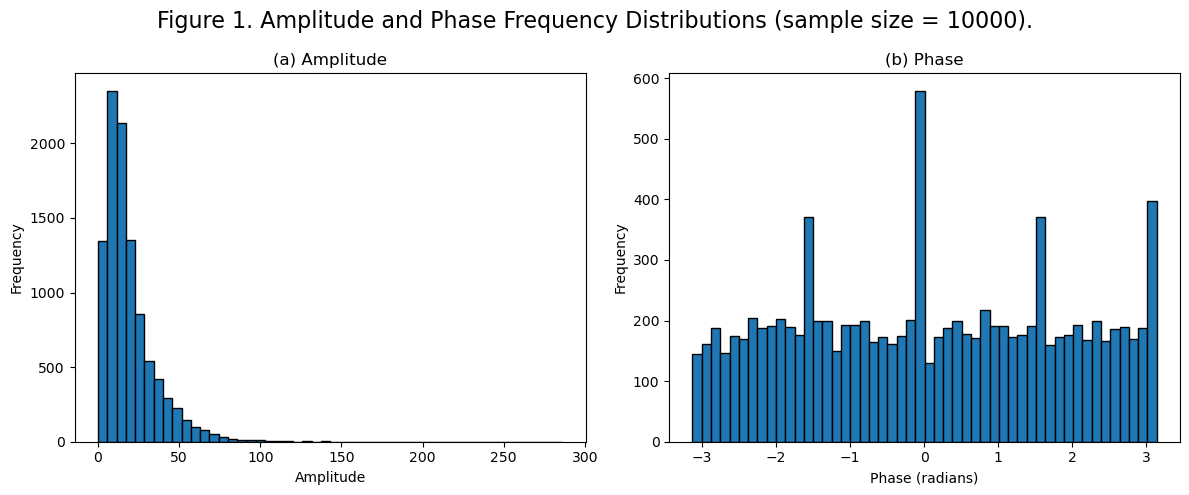

In [23]:
# Plot histograms of raw amplitude and phase (randomly sampled)
sample_size = 10000
vh_mag_sample = np.random.choice(vh_mag.ravel(), sample_size, replace=False)
vh_phase_sample = np.random.choice(vh_phase.ravel(), sample_size, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram on the first subplot
axes[0].hist(vh_mag_sample, bins=50, edgecolor='black')
axes[0].set_title("(a) Amplitude")
axes[0].set_xlabel("Amplitude")
axes[0].set_ylabel("Frequency")

# Plot histogram on the second subplot
axes[1].hist(vh_phase_sample, bins=50, edgecolor='black')
axes[1].set_title("(b) Phase")
axes[1].set_xlabel("Phase (radians)")
axes[1].set_ylabel("Frequency")

# Add super title
fig.suptitle("Figure 1. Amplitude and Phase Frequency Distributions (sample size = 10000).", fontsize=16)

# Improve layout and show plot
plt.tight_layout()
plt.show()

# free up memory
vh_mag = None
vh_phase = None
slc_data = None

**Observations:**
* The actual amplitude range for this image is [0.0, 2684.2] and the actual mean/median values are 19.3 and 15.0 respectively. The distribution is right skewed, starts at zero and has a long tail, resembling a Raleigh distribution, which is typical for this type of data (see Figure 1(a)).
* Phase range is centred on zero radians with values in the range $(-\pi, \pi]$ and essentially distribution uniform across the range but with prominent high frequency peaks around $0$, $\pm\pi/2$ and $\pi$ (see Figure 1(b)).
* phase_max is effectively equal to $\pi$ (discounting a small floating-point precision error) while the minimum phase is very close to $-\pi$. These min/max values are characteristic across the 150 images.

**Pre-processing recommendations: Scaling and Normalisation**
* **Amplitude:** Logarithmic (decibel) transformation to compress dynamic range:
  
$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad vh\_mag\_db = 20\log_{10}(vh\_mag + \epsilon)$,

$\quad~~$ where $\epsilon$ is some small number (e.g. $10^-6$) to prevent log(0) errors, then normalise dB value to [0, 1] using min/max normalisation or percentile clipping to manage outliers.

$\quad~~$ Note: A factor of 20 is appropriate for decibel conversion of field measurements such has amplitude and maintains consistency with radar and SAR processing conventions.

* **Phase:** The focus is on maintaining relative structure. Phase is inherently circular/periodic; representing phase as sine and cosine components respects the circular nature of phase and can be more suitable for training a neural network (eliminates the phase wraparound problem while keeping values in a well-behaved range). This representation only requires mapping the values to within the range expected for YOLO-compatibility ([-1, 1] -> [0,1]):

 $\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad phase\_sin\_norm = \frac{(phase\_sin + 1)}{2}\quad\text{and}$
 
 $\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad phase\_cos\_norm = \frac{(phase\_cos + 1)}{2}$.

#### 4.2.3 Displaying an SLC VH-polarisation image

Plot one swath of an SLC VH-polarisation scene from the validation partition, with 'HIGH' confidence labels.
(The same image array in Section 4.1 is used here again).

Note: The image is scaled, clipped, downsampled and the complex amplitude and phase data mapped into real intensity values for display purposes.

Build the image filepath

In [24]:
# Read the config.yaml file and set the SARFish data root directory
SARFish_root_directory = config['SARFish_root_directory']
product_type = config['product_type']
os.environ['SARFISH_ROOT_DIRECTORY'] = SARFish_root_directory

In [25]:
# Read correspondences file
xView3_SLC_GRD_correspondences = pd.read_csv("xView3_SLC_GRD_correspondences.csv") # in current working directory ("SARFish/working/")

# Extract the validation partition row entry for scene_Id '5c3d986db930f848v' from the xView3_SLC_GRD_correspondences.csv file
correspondence = xView3_SLC_GRD_correspondences[xView3_SLC_GRD_correspondences['scene_id'] == '5c3d986db930f848v'].squeeze()
# Print extracted row entry details
correspondence

DATA_PARTITION                                                                                  validation
scene_id                                                                                 5c3d986db930f848v
GRD_product_identifier                 S1B_IW_GRDH_1SDV_20200803T075721_20200803T075746_022756_02B2FF_033A
GRD_md5sum                                                                3f8ec460304f087c8f9a59b7c0897561
GRD_vh                        s1b-iw-grd-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.tiff
GRD_vv                        s1b-iw-grd-vv-20200803t075721-20200803t075746-022756-02b2ff-001_SARFish.tiff
GRD_vh_annotation                      s1b-iw-grd-vh-20200803t075721-20200803t075746-022756-02b2ff-002.xml
GRD_vv_annotation                      s1b-iw-grd-vv-20200803t075721-20200803t075746-022756-02b2ff-001.xml
SLC_product_identifier                 S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2
SLC_md5sum                           

In [26]:
# First set the required swath index of the selected scene
swath_index = 2 # swath 2 of 3
# Now build the path
measurement_path_SLC = Path(SARFish_root_directory, product_type, correspondence['DATA_PARTITION'], 
                            f"{correspondence['SLC_product_identifier']}.SAFE",
                            "measurement", correspondence[f'SLC_swath_{swath_index}_vh'])
# Check the path by printing it 
measurement_path_SLC

PosixPath('/group/pmc044/data/SARFish/SLC/validation/S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2.SAFE/measurement/s1b-iw2-slc-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.tiff')

Load, prepare and plot the SLC image

In [27]:
# Set a scale factor to be used for downsampling the image for display
scale_factor = 2 # retain every other pixel

# Unpack image from GeoTIFF as a NumPy array
data_SLC, nodata_mask_SLC, _, _ = load_GeoTiff(str(measurement_path_SLC))

# Apply decibel scaling to image
scaled_data_SLC = scale_sentinel_1_image(data_SLC, nodata_mask_SLC, product_type = "SLC")
data_SLC = None # free up memory

# Clip the scaled data
clipped_scaled_data_SLC = np.clip(scaled_data_SLC, 15, 60)
scaled_data_SLC = None # free up memory

# Downsample the image
clipped_scaled_data_SLC_resized = clipped_scaled_data_SLC[::scale_factor, ::scale_factor]
clipped_scaled_data_SLC = None # free up memory

# Downsample the nodata mask
nodata_mask_SLC_resized = nodata_mask_SLC[::scale_factor, ::scale_factor]

# Plot the final image
plot_SLC = SARFish_Plot(clipped_scaled_data_SLC_resized, nodata_mask_SLC_resized,
                        title = f"SLC VH-polarisation product with labels, swath: {swath_index}", show=True)

# Clean up remaining intermediate products too free up memory
nodata_mask_SLC_resized = None
clipped_scaled_data_SLC_resized = None

Load and display groundtruth labels

In [28]:
groundtruth_SLC = pd.read_csv('./SARFish_labels/validation/SLC/SLC_validation_labels.csv')
groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['SLC_product_identifier'] == correspondence['SLC_product_identifier']]
groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['confidence'] == 'HIGH']

In [29]:
# Scale down the bounding box and target coordinates the match the image scale
groundtruth_SLC[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']] = \
groundtruth_SLC[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']].apply(lambda x: round(x / scale_factor))

In [30]:
# Plot the 'HIGH' confidence labels on the image currently displayed in the pop-up interactive window
swath_groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['swath_index'] == swath_index]
plot_SLC.add_bboxes(swath_groundtruth_SLC[['left', 'right', 'bottom', 'top']])
plot_SLC.add_labels(columns = swath_groundtruth_SLC['detect_scene_column'], rows = swath_groundtruth_SLC['detect_scene_row'],
                    categories = swath_groundtruth_SLC[['detect_id', 'is_vessel', 'is_fishing', 'vessel_length_m', 'confidence']],
                    legend_label = "groundtruth", color = "yellow")

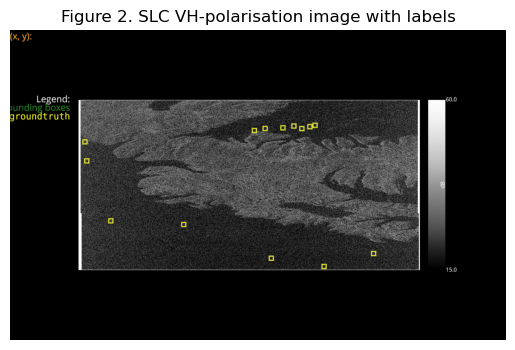

In [31]:
# Capture and display the same image inline using matplotlib
import matplotlib.pyplot as plt

img = plot_SLC.render()  # Capture the VisPy canvas as an image
plt.title("Figure 2. SLC VH-polarisation image with labels")
plt.imshow(img)
plt.axis('off')
plt.show()

plot_SLC = None # free memory

Figure 2 above, is the scaled, clipped and downsampled version of the SLC VH-polarisation product for scene_id '5c3d986db930f848v' (swath 2). The complex amplitude and phase data have been mapped into real intensity values for the display. Yellow boxes represent the bounding-boxes of the groundtruth labels, representing fishing vessels or non-fishing-vessels and where confidence = 'HIGH'.

## 5. Pre-processing

### 5.1 Create image crops

Generate 96 x 96 pixel image crops from the raw image arrays saved to disk in Section 4.1. Each crop should be centred on a positive vessel detection location, with confidence level HIGH or MEDIUM, and have an associated bounding box.

Notes:

* Bounding box (BBox) annotations use inverse y-axis labeling i.e., image origin is bottom-left. This is corrected to top-left on-the-fly in the crop generating script `create_crop.py` below.
* True positive vessel detections with BBoxes that extend beyond crop boundaries by more than 5 pixels are skipped. BBoxes extending by <= 5 pixels are shrunk to match the crop dimensions.
* Crops where detections are close to the original image boundary are zero-padded to maintain a consistent crop-size. Crops with excessive padding (i.e., where padding encroaches on the BBox) are, as a rule, rejected. 
* The crop size of 96 x 96 pixels was chosen because it encapsulates most of the largest vessels in the dataset while minimising the background. Moreover, being a square crop-size of a multiple of 32, it is optimal for more efficient processing by models like YOLO.

In [32]:
# Create training image crops - see config.yaml for configuration parameters, crops_log for full logging report.
#!./create_crop.py

In [33]:
# Print the processing summary from the crops_log
!awk '/PROCESSING SUMMARY/ {found=1} found' ./crops_log

PROCESSING SUMMARY
Number of input images processed: 135
Total crops of size 96 x 96 created: 3577
Images with no crops created: 11
Crops with padding applied: 5
Crops with bounding box shrunk: 17
Crops skipped (bounding box exceeds crop boundary): 26
Actual image files written: 3577
Actual label files written: 3577
Padding strategy: Zero padding (pad_value=0) for complex64 SAR data
Crop summary saved to: /group/pmc044/data/Generated/SLC/train/crops/crop_summary.csv
Total crops processed: 3577


In [34]:
# Create a list of of all 11 disqualified image arrays for reference
command = "awk -v pat='No crops created' '$0 ~ pat {print fname} {fname = $2}' ./crops_log"
disqualified_images = extract_list_from_command(command, output_file="disqualified_images.txt", print_summary=True, columns=1, list_name="disqualified_images")

List saved to disqualified_images.txt

Total number of items in disqualified_images: 11
disqualified_images = ["s1a-iw1-slc-vh-20200522t050603-20200522t050631-032673-03c8c7-001_SARFish.npy"
                       ,"s1b-iw2-slc-vh-20200826t054009-20200826t054034-023090-02bd74-002_SARFish.npy"
                       ,"s1a-iw3-slc-vh-20200503t051346-20200503t051413-032396-03c03f-003_SARFish.npy"
                       ,"s1a-iw3-slc-vh-20200126t175311-20200126t175336-030975-038e94-003_SARFish.npy"
                       ,"s1a-iw3-slc-vh-20200618t051930-20200618t051955-033067-03d4a2-003_SARFish.npy"
                       ,"s1a-iw3-slc-vh-20201121t175320-20201121t175345-035350-04214d-003_SARFish.npy"
                       ,"s1a-iw1-slc-vh-20200824t052155-20200824t052223-034044-03f3b6-001_SARFish.npy"
                       ,"s1a-iw2-slc-vh-20200824t052156-20200824t052224-034044-03f3b6-002_SARFish.npy"
                       ,"s1a-iw3-slc-vh-20200907t050726-20200907t050751-034248-03fad3-003

Comments:

From Section 4.1, we saw there are a total of 3,603 positive vessel detection labels in the train dataset that fit the criteria defined in Section 2.2. The *crops_log* generated by the `create_crop.py` script reports that of the 135 input swaths (aka images) **3,577** image crops were created. **26** potential crops were skipped because the bounding boxes fell partially outside of the crop boundary by more than 5 pixels while **17** were retained by shrinking the edges of the bounding box by up to 5 pixels at either end. Another **5** crops required padding due to vessel detections very close to the image boundary. On visual inspection, **3** of the padded crops were rejected because the bounding boxes either straddled or lay very close to (within a few pixels) of the padded region. The log also reported that **11** input images failed label validation meaning no qualifying labels were present in the annotations file for these inputs. This was consistent with the observation in Section 4.1, i.e., for the 45 training scenes only 124 out of 135 images (aka swaths) had annotations with 'HIGH' or 'MEDIUM' confidence for positive vessel detections.

### 5.2 Crops analysis

In [35]:
# Analyse the magntiude and real components of crop pixels (all crops) to determine optimal visualisation parameters
stats, mag_vals, log_vals, real_vals = analyse_crop_statistics('.') # base path to 'images' directory is current working directory

Analysing 3577 crop files...


Processing crops: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3577/3577 [00:34<00:00, 102.75it/s]


In [37]:
# Print the formatted statistical summary with recommendations
print_statistics_summary(stats)


SAR CROP STATISTICS SUMMARY
Files analyzed: 3,577
Total pixels: 32,965,632

MAGNITUDE STATISTICS:
  Min: 0.00
  Max: 4369.43
  Mean: 15.43
  Std: 22.13

  Percentiles:
     1%:     1.00
     5%:     2.83
    25%:     7.21
    50%:    12.08
    75%:    18.79
    95%:    33.06
    99%:    70.00

LOG-MAGNITUDE (dB) STATISTICS:
  Min: -200.00 dB
  Max: 72.81 dB
  Mean: 19.60 dB
  Std: 19.45 dB

  Percentiles:
     1%:     0.00 dB
     5%:     9.03 dB
    25%:    17.16 dB
    50%:    21.64 dB
    75%:    25.48 dB
    95%:    30.39 dB
    99%:    36.90 dB

REAL PART STATISTICS:
  Min: -3141.00
  Max: 3277.00
  Mean: 0.01
  Std: 19.09

  Percentiles:
     1%:   -34.00
     5%:   -20.00
    25%:    -7.00
    50%:     0.00
    75%:     7.00
    95%:    20.00
    99%:    34.00

RECOMMENDED NORMALISATION PARAMETERS:
For MAGNITUDE (99% coverage):
  amp_min = 1.0
  amp_max = 70.0

For LOG-MAGNITUDE (99% coverage):
  log_min = 0.0
  log_max = 36.9

For LOG-MAGNITUDE (95% coverage - more conservativ

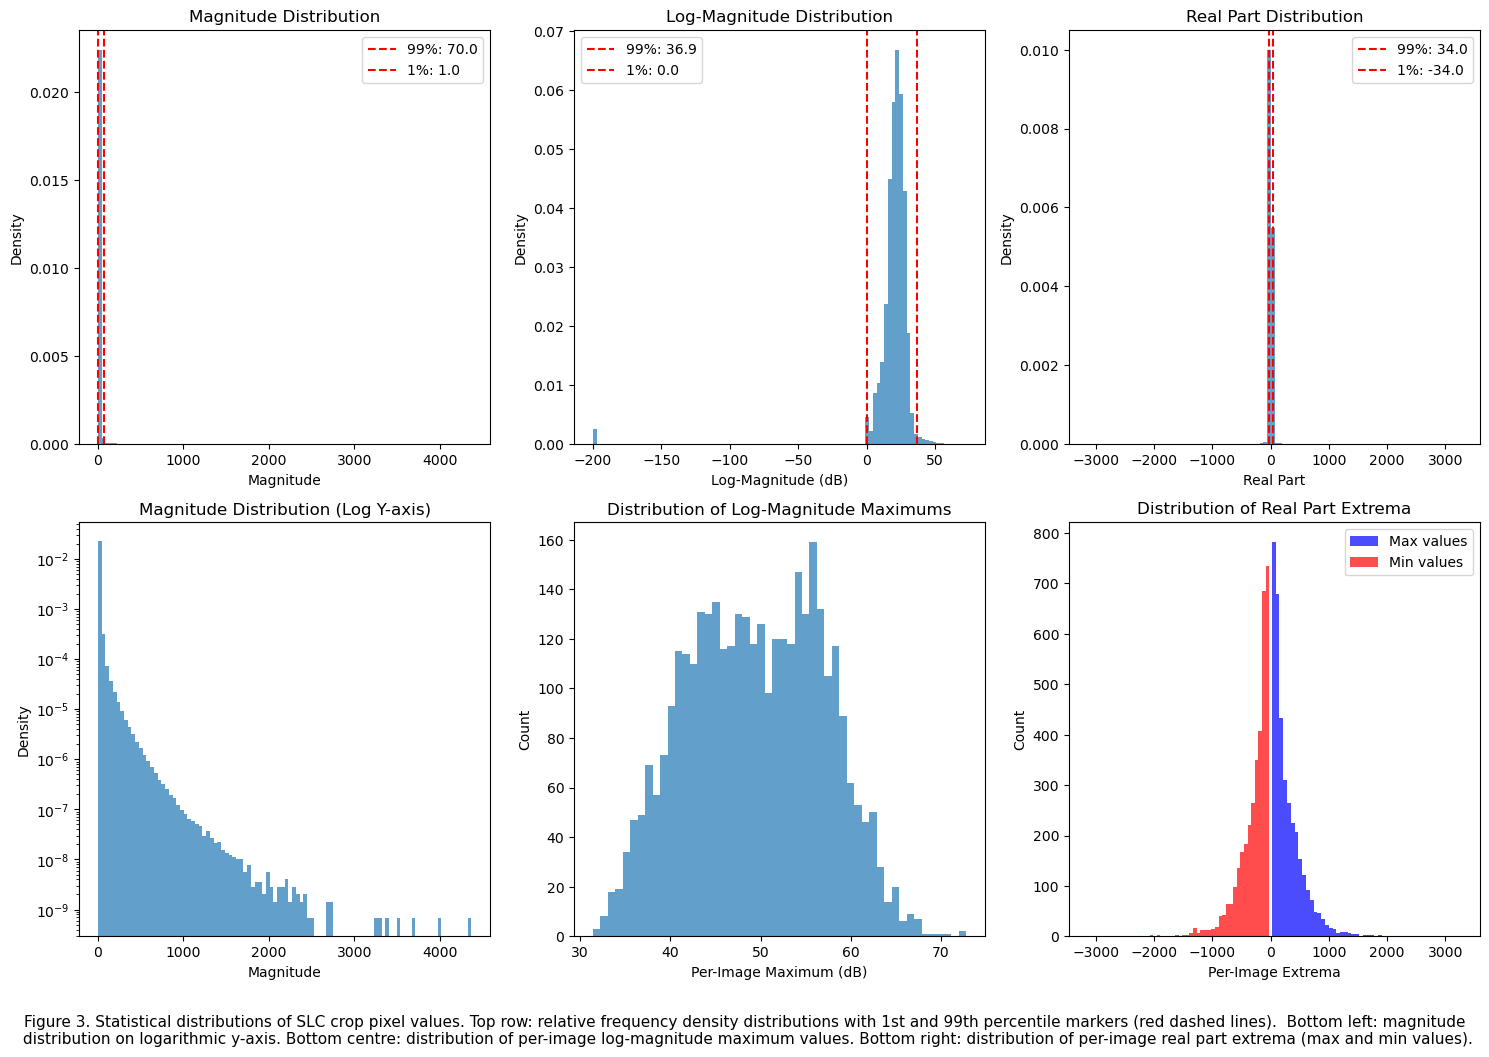

In [38]:
# Plot distribution visualizations
plot_distribution_analysis(stats, mag_vals, log_vals, real_vals)

Comments:

* Only the magnitude and real components, measured across all 3577 crops, are considered here, principally to determine optimal visualisation parameters.
* The recommended normalisaton parameters determined above will be used for visualisations henceforth, where applicable.

### 5.3 Crop visualisation

#### 5.3.1 Interactive visual tool

An interactive tool to visualise the extracted crops was developed. The tool offers a selection of display modes, including magnitude (default) and decibel-scaled magnitude, phase, sin(phase), cos(phase), real and imaginary. The number of randomly selected image samples to view is user-selectable (default=50). It also offers a single-image view mode where the user nominates a specific image to view at launch. Optionally, bounding boxes can also displayed with the class of the detected object indicated ('is_fishing' or 'is_vessel').

In [39]:
!./visualise_crops.py --help

usage: visualise_crops.py [-h] --images IMAGES [--labels LABELS]
                          [--mode {magnitude,log_magnitude,phase,sin_phase,cos_phase,real,imag}]
                          [--samples SAMPLES] [--single SINGLE]

Visualize 2D complex64 SAR crops with optional YOLO labels

optional arguments:
  -h, --help            show this help message and exit
  --images IMAGES, -i IMAGES
                        Directory containing .npy image files (complex64, 2D)
  --labels LABELS, -l LABELS
                        Directory containing .txt label files (YOLO format,
                        optional)
  --mode {magnitude,log_magnitude,phase,sin_phase,cos_phase,real,imag}, -m {magnitude,log_magnitude,phase,sin_phase,cos_phase,real,imag}
                        Initial display mode (default: magnitude)
  --samples SAMPLES, -n SAMPLES
                        Number of images to randomly sample for viewing
                        (default: 50, use large number to view all)
  --single SINGL

In [40]:
# launch the interactive SAR image browser in raw magnitude (default) mode (swichable during the session)
!./visualise_crops.py -i images -l labels

Sample selection: Randomly sampled 50 images from 3577 total
QStandardPaths: XDG_RUNTIME_DIR points to non-existing path '/run/user/11714', please create it with 0700 permissions.
Navigation:
  → : next crop
  ← : previous crop
  ↑ : next display mode
  ↓ : previous display mode
  Esc : quit

Display modes: magnitude, log_magnitude, phase, sin_phase, cos_phase, real, imag
Sample size: 50 images


#### 5.3.2 Padded crop QC

Visually examine the 5 padded crops created earlier

In [41]:
# Create a list of the images that have been padded
command = "awk -v pat='PADDED' '$0 ~ pat {print $2 \".npy\"}' ./crops_log"
padded_images = extract_list_from_command(command, output_file="padded_images.txt", print_summary=True, columns=1, list_name="padded_images")

List saved to padded_images.txt

Total number of items in padded_images: 5
padded_images = ["a6073537a4ea5fb9v_057.32055021000000039066_008.51600360299999969982_swath1.npy"
                 ,"c5ea6da5405bfac0v_057.64343044000000304550_009.98391505700000081447_swath3.npy"
                 ,"fc483682c621b54bv_004.30196294300000037225_008.16526335400000036202_swath2.npy"
                 ,"fc483682c621b54bv_004.32414975499999965081_008.27698049800000035248_swath2.npy"
                 ,"3ceef682fbe4930av_004.27261539000000034605_008.55530834800000050677_swath1.npy"]


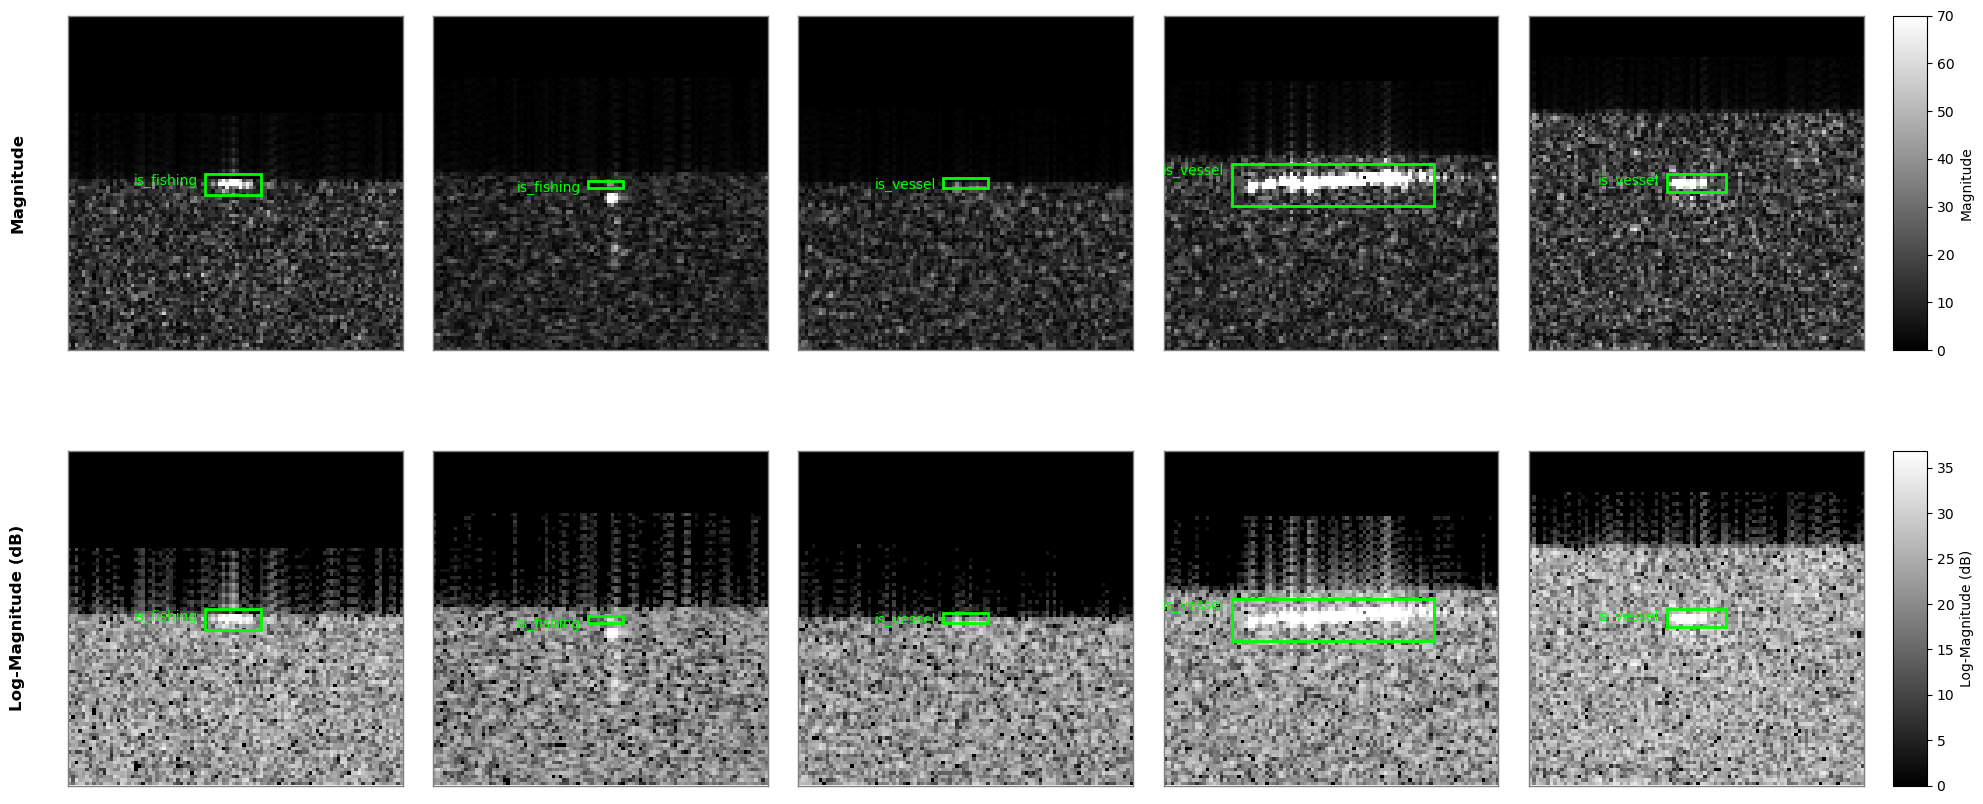

Normalisation parameters - Magnitude: [0.0, 70.0], Log-Magnitude: [0.0, 36.9] dB, Real: [-35, 35]
All images normalised to [0, 1] range using above parameters


In [42]:
# Plot each padded crops in both magnitude and log-magnitude display modes ('real' is an alternative display mode)
crop_compare(padded_images, base_dir='.',
             amp_min=0.0, amp_max=70.0,
             log_min=0.0, log_max=36.9,
             real_min=-35, real_max=35,
             mode_row1='magnitude', mode_row2='log-magnitude')

Comments:

The plots above display the 5 padded crops in two separate display modes, raw magnitude and decibel-scaled magnitude.

The first crop image shows a vessel positioned right up against the padded region border (original image boundary). The vessel signature is well defined, clearly oriented horizontally and consistent with its BBox placement. The faint vertical echoes extending into the padded region are typical of sidelobe artefacts commonly seen in SAR imagery.

In the second crop, the BBox is poorly positioned over a vessel which appears to have a *vertical* rather than the horizontal orientation implied by the BBox. The vessel and BBox are also in very close proximity to the padded region border. It is unclear whether the faint echo emanating directly from the end of the vessel crossing into the padded region, is part of the vessel signature proper or not.

The third crop image displays a highly questionable detection, with the 'vessel' pixels, positioned right on the border of the padded region, and having intensities virtually indistinguishable from the background.

The last two images show two distinct vessel detections, including one of a very large vessel (**100.5 m** in length^2). Despite the close proximity of the larger vessel to the image border, this crop, and the last, are considered acceptable for use in training. The first crop is marginal however the second and third are considered unacceptable. 

[2] Vessel length data obtained from *SLC_validation_labels.csv* sourced from [xView3 website](https://iuu.xview.us/)

### 5.4 Scaling and normalisation

This section applies scaling and percentile clipping to amplitude data and sine and cosine transformations to phase data, in each training image crop. This is followed by normalisation to [0, 1] for YOLO compatiblity. The approach follows the recommendations in Section 4.2.1 and is informed by the statistical analysis of cropped images in Section 5.2. The final processing stage involves stacking the three components (amplitude_norm, phase_sin_norm and phase_cos_norm) in order to simulate the 3-channel RGB image input format expected by YOLO models (3, Height, Width).

Note: With respect to amplitudes, it is assumed that non-fishing vessels display greater variability in amplitude intensity signatures relative to fishing vessels. This is because of their large variability in size, shape and construction. For example, large cargo/container ships generally show very high intensities resulting from corner reflections and metal structures, while smaller passenger ferries display more moderate intensities. Add to this the different orientations and aspect ratios, then a broad range of different backscatter levels could be expected. In contrast, fishing vessel backscatter levels would be expected to be mostly in the moderate range due to smaller size, different construction and materials used (wooden hulls as opposed to metal.

In [43]:
# Display the core processing script command line parameters and usage examples for standalone use
!./complex_scale_and_norm.py --help

usage: complex_scale_and_norm.py [-h] [--output-dir OUTPUT_DIR]
                                 [--nan-strategy {skip,zero,mean,interpolate}]
                                 [--epsilon EPSILON]
                                 [--global-norm-params AMP_MIN AMP_MAX]
                                 [--verbose]
                                 input_array

Process complex-valued SAR data into normalised 3-channel format for YOLO

positional arguments:
  input_array           Path to input numpy array file (.npy)

optional arguments:
  -h, --help            show this help message and exit
  --output-dir OUTPUT_DIR
                        Output directory (default: current working directory)
  --nan-strategy {skip,zero,mean,interpolate}
                        Strategy for handling NaN/invalid values (default:
                        skip)
  --epsilon EPSILON     Small value to prevent log(0) in amplitude processing
                        (default: 1e-6)
  --global-norm-params AMP_MIN A

Batch process the image crops created in Section 5.1 using the `batch_process_sar_data() function` which invokes the `complex_scale_and_norm.py` script. 

Use the 1st and 99th percentile of amplitude values (1.0 and 70.0 respectively) for the crops dataset computed in Section 5.2 to clip the amplitudes prior to scaling. 

In [44]:
!./batch_sar_processing.py --config config.yaml

Batch SAR Data Processing
✓ Configuration loaded from: config.yaml
✓ Logging enabled: batch_sar_processing.log
✓ Configuration validated
✓ Output directory: /group/pmc044/data/Generated/SLC/train/crops/images_proc/
Found 3577 files matching pattern '*.npy' in /group/pmc044/data/Generated/SLC/train/crops/images/

Processing Configuration:
  Input directory: /group/pmc044/data/Generated/SLC/train/crops/images/
  Output directory: /group/pmc044/data/Generated/SLC/train/crops/images_proc/
  NaN strategy: skip
  Epsilon: 1e-6
  Global normalisation: Yes
    Amplitude parameters: [1e-06, 70.0]
    Phase normalization: automatic via sine/cosine transformation
  Parallel processing: Yes
  Skip existing: True
Processing 3577 files with 4 workers (verbose=False)...

Processing Summary
Total files: 3577
Successful: 3577
Failed: 0
Processing time: 1.52 seconds


In [45]:
# Print the processing summary from batch_sar_processing.log if needed
!head -n 5 ./batch_sar_processing.log; tail -n 6 ./batch_sar_processing.log

2025-07-06 19:42:12,606 - INFO - Batch SAR processing started
2025-07-06 19:42:12,606 - INFO - Configuration: {'input_dir': '/group/pmc044/data/Generated/SLC/train/crops/images/', 'output_dir': '/group/pmc044/data/Generated/SLC/train/crops/images_proc/', 'script_path': 'complex_scale_and_norm.py', 'nan_strategy': 'skip', 'epsilon': '1e-6', 'verbose': False, 'global_norm_params': [0.0, 70.0], 'max_workers': 4, 'file_pattern': '*.npy', 'skip_existing': True, 'log_file': 'batch_sar_processing.log'}
2025-07-06 19:42:12,606 - INFO - Configuration validated successfully
2025-07-06 19:42:12,607 - INFO - Output directory created/verified: /group/pmc044/data/Generated/SLC/train/crops/images_proc/
2025-07-06 19:42:12,625 - INFO - Found 3577 files to process
2025-07-06 19:42:14,146 - INFO - Batch processing completed
2025-07-06 19:42:14,146 - INFO - Total files: 3577
2025-07-06 19:42:14,146 - INFO - Successful: 3577
2025-07-06 19:42:14,146 - INFO - Failed: 0
2025-07-06 19:42:14,146 - INFO - Proce

Load and display vital the stats for one scaled and normalised image crop array created in the previous cell:

In [50]:
# Build path to the processed crop images 
images_proc_SLC_path = Path(Generated_root_directory, product_type, "train", "crops", "images_proc")
# Check the path by printing it
images_proc_SLC_path

PosixPath('/group/pmc044/data/Generated/SLC/train/crops/images_proc')

In [51]:
# Load a single normalised crop image
slc_crop_norm = np.load(f"{images_proc_SLC_path}/0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_proc.npy")

In [52]:
# Compute some vital statistics of the normalised crop image
slc_crop_norm_vitals = {
    "size": slc_crop_norm.size, 
    "shape": slc_crop_norm.shape, 
    "dtype": slc_crop_norm.dtype, 
    "amp_min": np.min(slc_crop_norm[:, :, 0]), 
    "amp_max": np.max(slc_crop_norm[:, :, 0]), 
    "phase_sin_min": np.min(slc_crop_norm[:, :, 1]), 
    "phase_sin_max": np.max(slc_crop_norm[:, :, 1]),
    "phase_cos_min": np.min(slc_crop_norm[:, :, 2]), 
    "phase_cos_max": np.max(slc_crop_norm[:, :, 2])    
}
slc_crop_norm_vitals

{'size': 27648,
 'shape': (3, 96, 96),
 'dtype': dtype('float32'),
 'amp_min': 0.0,
 'amp_max': 1.0,
 'phase_sin_min': 0.0,
 'phase_sin_max': 1.0,
 'phase_cos_min': 0.0,
 'phase_cos_max': 1.0}

Shape of array and all channel ranges in expected range (YOLO-compatible)

### 5.5 Data augmentation

[Click here to visit YoTube on Mosaic Data Augmentation](https://www.youtube.com/watch?v=V6uj-eGmE7g&list=PLp5OuA3mFH5JTuKuk07wEMDylDF-Slo2W&index=21)

## 6. Modelling

#### Load the model

In [53]:
from ultralytics import YOLO
import torch

In [54]:
# Load the model
model = YOLO('yolo11n.pt')

  0%|          | 0.00/5.35M [00:00<?, ?B/s]

#### Verify installation

In [55]:
# Run inference on an image
results = model('https://ultralytics.com/images/bus.jpg')

  0%|          | 0.00/134k [00:00<?, ?B/s]

image 1/1 /group/pmc044/SARship-detect/working/bus.jpg: 640x480 4 persons, 1 bus, 465.3ms
Speed: 66.7ms preprocess, 465.3ms inference, 577.2ms postprocess per image at shape (1, 3, 640, 480)


In [57]:
# Print detailed results with bounding boxes and confidence
for r in results:
    print(f"Detected {len(r.boxes)} objects")
    
    # Access bounding box information
    if r.boxes is not None:
        boxes = r.boxes.xyxy  # bounding boxes in xyxy format
        confidences = r.boxes.conf  # confidence scores
        classes = r.boxes.cls  # class indices
        
        print("\nDetailed detections:")
        for i, (box, conf, cls_idx) in enumerate(zip(boxes, confidences, classes)):
            x1, y1, x2, y2 = box.tolist()
            class_name = r.names[int(cls_idx)]
            
            print(f"Object {i+1}:")
            print(f"  Class: {class_name} (ID: {int(cls_idx)})")
            print(f"  Confidence: {conf:.4f}")
            print(f"  Bounding box: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")
            print(f"  Box format: (x1, y1, x2, y2)")
            print()

Detected 5 objects

Detailed detections:
Object 1:
  Class: bus (ID: 5)
  Confidence: 0.9402
  Bounding box: (3.8, 229.4, 796.2, 728.4)
  Box format: (x1, y1, x2, y2)

Object 2:
  Class: person (ID: 0)
  Confidence: 0.8882
  Bounding box: (671.0, 394.8, 809.8, 878.7)
  Box format: (x1, y1, x2, y2)

Object 3:
  Class: person (ID: 0)
  Confidence: 0.8783
  Bounding box: (47.4, 399.6, 239.3, 904.2)
  Box format: (x1, y1, x2, y2)

Object 4:
  Class: person (ID: 0)
  Confidence: 0.8558
  Bounding box: (223.1, 408.7, 344.5, 860.4)
  Box format: (x1, y1, x2, y2)

Object 5:
  Class: person (ID: 0)
  Confidence: 0.6219
  Bounding box: (0.0, 556.1, 68.9, 872.4)
  Box format: (x1, y1, x2, y2)



In [58]:
# Save results with bounding boxes drawn
results[0].save('output_with_boxes.jpg')

'output_with_boxes.jpg'

In [59]:
# Access the underlying PyTorch model
pytorch_model = model.model

#### Examine the architecture

In [60]:
# View the model architecture
print(pytorch_model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(64,

UNDER CONSTRUCTION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import gc
from typing import List, Tuple, Dict, Optional

def analyze_vessel_crop(complex_crop, crop_id=None, center_radius=10):
    """
    Analyze a single 64x64 vessel crop to extract vessel and background characteristics.
    
    Parameters:
    -----------
    complex_crop : numpy.ndarray
        64x64 complex-valued SAR crop with vessel at center
    crop_id : str, optional
        Identifier for this crop
    center_radius : int
        Radius around center to consider as vessel region
    
    Returns:
    --------
    dict : Analysis results including vessel/background statistics
    """
    h, w = complex_crop.shape
    center_x, center_y = w // 2, h // 2
    
    # Create masks for vessel (center) and background regions
    y_coords, x_coords = np.ogrid[:h, :w]
    vessel_mask = ((x_coords - center_x)**2 + (y_coords - center_y)**2) <= center_radius**2
    background_mask = ~vessel_mask
    
    # Extract amplitude and phase
    amplitude = np.abs(complex_crop)
    phase = np.angle(complex_crop)
    
    # Vessel statistics
    vessel_amp = amplitude[vessel_mask]
    vessel_phase = phase[vessel_mask]
    
    # Background statistics  
    bg_amp = amplitude[background_mask]
    bg_phase = phase[background_mask]
    
    # Remove invalid values
    vessel_amp = vessel_amp[np.isfinite(vessel_amp) & (vessel_amp > 0)]
    vessel_phase = vessel_phase[np.isfinite(vessel_phase)]
    bg_amp = bg_amp[np.isfinite(bg_amp) & (bg_amp > 0)]
    bg_phase = bg_phase[np.isfinite(bg_phase)]
    
    return {
        'crop_id': crop_id,
        'vessel_amp_mean': np.mean(vessel_amp) if len(vessel_amp) > 0 else 0,
        'vessel_amp_std': np.std(vessel_amp) if len(vessel_amp) > 0 else 0,
        'vessel_amp_max': np.max(vessel_amp) if len(vessel_amp) > 0 else 0,
        'bg_amp_mean': np.mean(bg_amp) if len(bg_amp) > 0 else 0,
        'bg_amp_std': np.std(bg_amp) if len(bg_amp) > 0 else 0,
        'contrast_ratio': (np.mean(vessel_amp) / np.mean(bg_amp)) if len(bg_amp) > 0 and np.mean(bg_amp) > 0 else 0,
        'vessel_pixels': len(vessel_amp),
        'bg_pixels': len(bg_amp),
        'vessel_phase_var': np.var(vessel_phase) if len(vessel_phase) > 0 else 0,
        'bg_phase_var': np.var(bg_phase) if len(bg_phase) > 0 else 0
    }

def create_crop_histogram(complex_crops, crop_ids=None, n_bins_phase=64, n_bins_amp=32,
                         analysis_type='vessel_focused', center_radius=10):
    """
    Create phase-amplitude histogram for vessel crops.
    
    Parameters:
    -----------
    complex_crops : list or numpy.ndarray
        List of 64x64 complex crops, or single 3D array (N, 64, 64)
    crop_ids : list, optional
        Identifiers for each crop
    n_bins_phase : int
        Number of phase bins
    n_bins_amp : int  
        Number of amplitude bins
    analysis_type : str
        'vessel_focused' - Focus on vessel regions only
        'full_crop' - Analyze entire crop
        'comparative' - Compare vessel vs background
    center_radius : int
        Radius for vessel region definition
    """
    
    # Handle input format
    if isinstance(complex_crops, np.ndarray):
        if complex_crops.ndim == 2:
            complex_crops = [complex_crops]
        elif complex_crops.ndim == 3:
            complex_crops = [complex_crops[i] for i in range(complex_crops.shape[0])]
    
    n_crops = len(complex_crops)
    if crop_ids is None:
        crop_ids = [f"Crop_{i:03d}" for i in range(n_crops)]
    
    print(f"Processing {n_crops} vessel crops...")
    
    # Collect statistics for all crops
    crop_stats = []
    all_vessel_amp = []
    all_vessel_phase = []
    all_bg_amp = []
    all_bg_phase = []
    
    for i, crop in enumerate(complex_crops):
        if crop.shape != (64, 64):
            print(f"Warning: Crop {i} has shape {crop.shape}, expected (64, 64)")
            continue
            
        stats = analyze_vessel_crop(crop, crop_ids[i], center_radius)
        crop_stats.append(stats)
        
        # Extract vessel and background data
        h, w = crop.shape
        center_x, center_y = w // 2, h // 2
        y_coords, x_coords = np.ogrid[:h, :w]
        vessel_mask = ((x_coords - center_x)**2 + (y_coords - center_y)**2) <= center_radius**2
        
        amplitude = np.abs(crop)
        phase = np.angle(crop)
        
        if analysis_type == 'vessel_focused':
            vessel_amp_crop = amplitude[vessel_mask]
            vessel_phase_crop = phase[vessel_mask]
            valid_mask = np.isfinite(vessel_amp_crop) & (vessel_amp_crop > 0) & np.isfinite(vessel_phase_crop)
            all_vessel_amp.extend(vessel_amp_crop[valid_mask])
            all_vessel_phase.extend(vessel_phase_crop[valid_mask])
            
        elif analysis_type == 'full_crop':
            amp_flat = amplitude.ravel()
            phase_flat = phase.ravel()
            valid_mask = np.isfinite(amp_flat) & (amp_flat > 0) & np.isfinite(phase_flat)
            all_vessel_amp.extend(amp_flat[valid_mask])
            all_vessel_phase.extend(phase_flat[valid_mask])
            
        else:  # comparative
            # Vessel region
            vessel_amp_crop = amplitude[vessel_mask]
            vessel_phase_crop = phase[vessel_mask]
            valid_vessel = np.isfinite(vessel_amp_crop) & (vessel_amp_crop > 0) & np.isfinite(vessel_phase_crop)
            all_vessel_amp.extend(vessel_amp_crop[valid_vessel])
            all_vessel_phase.extend(vessel_phase_crop[valid_vessel])
            
            # Background region  
            bg_amp_crop = amplitude[~vessel_mask]
            bg_phase_crop = phase[~vessel_mask]
            valid_bg = np.isfinite(bg_amp_crop) & (bg_amp_crop > 0) & np.isfinite(bg_phase_crop)
            all_bg_amp.extend(bg_amp_crop[valid_bg])
            all_bg_phase.extend(bg_phase_crop[valid_bg])
    
    # Convert to numpy arrays
    all_vessel_amp = np.array(all_vessel_amp)
    all_vessel_phase = np.array(all_vessel_phase)
    
    if len(all_vessel_amp) == 0:
        print("Error: No valid vessel pixels found!")
        return None, None, None
    
    print(f"Collected {len(all_vessel_amp):,} vessel pixels from {n_crops} crops")
    if analysis_type == 'comparative':
        print(f"Collected {len(all_bg_amp):,} background pixels")
        print(f"Vessel amplitude range: {np.min(all_vessel_amp):.4f} - {np.max(all_vessel_amp):.4f}")
        if len(all_bg_amp) > 0:
            print(f"Background amplitude range: {np.min(all_bg_amp):.4f} - {np.max(all_bg_amp):.4f}")
    
    # Phase bins
    phase_edges = np.linspace(-np.pi, np.pi, n_bins_phase + 1)
    
    # Create histograms
    if analysis_type == 'comparative' and len(all_bg_amp) > 0:
        all_bg_amp = np.array(all_bg_amp)
        all_bg_phase = np.array(all_bg_phase)
        
        # For comparative analysis, create amplitude bins that cover both vessel and background
        combined_amp = np.concatenate([all_vessel_amp, all_bg_amp])
        amp_min = np.percentile(combined_amp, 1)
        amp_max = np.percentile(combined_amp, 99.5)
        
        # Ensure minimum value is positive for log scale
        amp_min = max(amp_min, 1e-6)
        amp_max = max(amp_max, amp_min * 10)  # Ensure meaningful range
        
        print(f"Combined amplitude range for binning: {amp_min:.6f} - {amp_max:.6f}")
        
        try:
            amp_edges = np.logspace(np.log10(amp_min), np.log10(amp_max), n_bins_amp + 1)
        except ValueError as e:
            print(f"Error creating log bins: {e}")
            print("Falling back to linear binning")
            amp_edges = np.linspace(amp_min, amp_max, n_bins_amp + 1)
        
        # Create separate histograms for vessel and background
        hist_vessel, _, _ = np.histogram2d(all_vessel_phase, all_vessel_amp, 
                                         bins=[phase_edges, amp_edges])
        hist_bg, _, _ = np.histogram2d(all_bg_phase, all_bg_amp,
                                     bins=[phase_edges, amp_edges])
    else:
        # Create amplitude bins - adaptive to vessel data range only
        amp_min = np.percentile(all_vessel_amp, 1)
        amp_max = np.percentile(all_vessel_amp, 99.5)
        
        # Ensure minimum value is positive for log scale
        amp_min = max(amp_min, 1e-6)
        amp_max = max(amp_max, amp_min * 10)  # Ensure meaningful range
        
        try:
            amp_edges = np.logspace(np.log10(amp_min), np.log10(amp_max), n_bins_amp + 1)
        except ValueError as e:
            print(f"Error creating log bins: {e}")
            print("Falling back to linear binning")
            amp_edges = np.linspace(amp_min, amp_max, n_bins_amp + 1)
        
        # Create visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Vessel histogram
        im1 = ax1.imshow(hist_vessel.T + 1, extent=[-np.pi, np.pi, 0, n_bins_amp],
                        origin='lower', aspect='auto', cmap='hot', norm=LogNorm())
        ax1.set_title(f'Vessel Regions (n={n_crops} crops)')
        ax1.set_xlabel('Phase (radians)')
        ax1.set_ylabel('Amplitude Bin')
        plt.colorbar(im1, ax=ax1, label='Frequency')
        
        # Background histogram
        im2 = ax2.imshow(hist_bg.T + 1, extent=[-np.pi, np.pi, 0, n_bins_amp],
                        origin='lower', aspect='auto', cmap='blues', norm=LogNorm())
        ax2.set_title('Background Regions')
        ax2.set_xlabel('Phase (radians)')
        ax2.set_ylabel('Amplitude Bin')
        plt.colorbar(im2, ax=ax2, label='Frequency')
        
        # Phase comparison
        phase_centers = (phase_edges[:-1] + phase_edges[1:]) / 2
        vessel_phase_dist = np.sum(hist_vessel, axis=1)
        bg_phase_dist = np.sum(hist_bg, axis=1)
        
        ax3.plot(phase_centers, vessel_phase_dist, 'r-', label='Vessel', linewidth=2)
        ax3.plot(phase_centers, bg_phase_dist, 'b-', label='Background', linewidth=2)
        ax3.set_xlabel('Phase (radians)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Phase Distribution Comparison')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Amplitude comparison
        amp_centers = np.sqrt(amp_edges[:-1] * amp_edges[1:])
        vessel_amp_dist = np.sum(hist_vessel, axis=0)
        bg_amp_dist = np.sum(hist_bg, axis=0)
        
        ax4.loglog(amp_centers, vessel_amp_dist + 1, 'r-', label='Vessel', linewidth=2)
        ax4.loglog(amp_centers, bg_amp_dist + 1, 'b-', label='Background', linewidth=2)
        ax4.set_xlabel('Amplitude')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Amplitude Distribution Comparison')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        main_hist = hist_vessel
        
    else:
        # Single histogram
        hist_2d, _, _ = np.histogram2d(all_vessel_phase, all_vessel_amp,
                                     bins=[phase_edges, amp_edges])
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Main histogram
        im1 = ax1.imshow(hist_2d.T + 1, extent=[-np.pi, np.pi, 0, n_bins_amp],
                        origin='lower', aspect='auto', cmap='plasma', norm=PowerNorm(gamma=0.5))
        title = f'Vessel Crops Phase-Amplitude ({analysis_type})'
        ax1.set_title(title)
        ax1.set_xlabel('Phase (radians)')
        ax1.set_ylabel('Amplitude Bin')
        plt.colorbar(im1, ax=ax1, label='Frequency')
        
        # Phase distribution
        phase_centers = (phase_edges[:-1] + phase_edges[1:]) / 2
        phase_dist = np.sum(hist_2d, axis=1)
        ax2.plot(phase_centers, phase_dist, 'g-', linewidth=2)
        ax2.set_xlabel('Phase (radians)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Phase Distribution')
        ax2.grid(True, alpha=0.3)
        
        # Amplitude distribution
        amp_centers = np.sqrt(amp_edges[:-1] * amp_edges[1:])
        amp_dist = np.sum(hist_2d, axis=0)
        ax3.loglog(amp_centers, amp_dist + 1, 'purple', linewidth=2)
        ax3.set_xlabel('Amplitude')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Amplitude Distribution')
        ax3.grid(True, alpha=0.3)
        
        # Crop statistics summary
        if crop_stats:
            contrast_ratios = [s['contrast_ratio'] for s in crop_stats if s['contrast_ratio'] > 0]
            vessel_amps = [s['vessel_amp_mean'] for s in crop_stats if s['vessel_amp_mean'] > 0]
            
            ax4.hist(contrast_ratios, bins=20, alpha=0.7, color='orange', edgecolor='black')
            ax4.set_xlabel('Vessel/Background Contrast Ratio')
            ax4.set_ylabel('Number of Crops')
            ax4.set_title(f'Contrast Distribution (n={len(contrast_ratios)})')
            ax4.grid(True, alpha=0.3)
        
        main_hist = hist_2d
    
    # Format phase ticks
    phase_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    phase_labels = ['-π', '-π/2', '0', 'π/2', 'π']
    for ax in fig.get_axes():
        if 'Phase' in ax.get_xlabel():
            ax.set_xticks(phase_ticks)
            ax.set_xticklabels(phase_labels)
    
    plt.tight_layout()
    
    # Summary statistics
    summary = {
        'n_crops': n_crops,
        'total_pixels': len(all_vessel_amp),
        'amp_range': (np.min(all_vessel_amp), np.max(all_vessel_amp)),
        'mean_contrast': np.mean([s['contrast_ratio'] for s in crop_stats if s['contrast_ratio'] > 0]),
        'crop_stats': crop_stats
    }
    
    return fig, main_hist, summary

def batch_process_crops(crop_directory=None, complex_crops=None, **kwargs):
    """
    Batch process multiple vessel crops.
    
    Parameters:
    -----------
    crop_directory : str, optional
        Directory containing .npy files of crops
    complex_crops : list/array, optional  
        Direct array of crops
    **kwargs : additional arguments for create_crop_histogram
    """
    
    if crop_directory is not None:
        import os
        crop_files = [f for f in os.listdir(crop_directory) if f.endswith('.npy')]
        crop_ids = [f.replace('.npy', '') for f in crop_files]
        complex_crops = [np.load(os.path.join(crop_directory, f)) for f in crop_files]
        print(f"Loaded {len(complex_crops)} crops from {crop_directory}")
    
    elif complex_crops is None:
        print("Error: Must provide either crop_directory or complex_crops")
        return None
        
    return create_crop_histogram(complex_crops, crop_ids, **kwargs)

# Example usage
if __name__ == "__main__":
    # Example: Create synthetic vessel crops for testing
    print("Creating example vessel crops...")
    
    # Generate synthetic 64x64 crops with vessels at center
    n_test_crops = 5
    test_crops = []
    
    for i in range(n_test_crops):
        # Create background sea clutter
        crop = (np.random.randn(64, 64) + 1j * np.random.randn(64, 64)) * 0.5
        
        # Add vessel signature at center
        center_x, center_y = 32, 32
        vessel_size = np.random.randint(6, 12)
        vessel_amp = np.random.uniform(3, 8)
        
        y_coords, x_coords = np.ogrid[:64, :64]
        vessel_mask = ((x_coords - center_x)**2 + (y_coords - center_y)**2) <= vessel_size**2
        
        # Add vessel with higher amplitude and specific phase pattern
        vessel_phase = np.random.uniform(-np.pi, np.pi)
        crop[vessel_mask] = vessel_amp * np.exp(1j * vessel_phase)
        
        test_crops.append(crop)
    
    # Test different analysis types
    analysis_types = ['vessel_focused', 'full_crop', 'comparative']
    
    for analysis in analysis_types:
        print(f"\n{'='*50}")
        print(f"Analysis type: {analysis}")
        print('='*50)
        
        fig, hist, summary = create_crop_histogram(
            test_crops,
            analysis_type=analysis,
            n_bins_phase=32,
            n_bins_amp=24,
            center_radius=8
        )
        
        if summary:
            print(f"Processed {summary['n_crops']} crops")
            print(f"Total pixels analyzed: {summary['total_pixels']:,}")
            print(f"Amplitude range: {summary['amp_range'][0]:.2f} - {summary['amp_range'][1]:.2f}")
            print(f"Mean contrast ratio: {summary['mean_contrast']:.2f}")
        
        plt.show()
        
        cont = input("Continue to next analysis? (y/n): ")
        if not cont.lower().startswith('y'):
            break